In [1]:
# Select TensorFlow 2 backend
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
# I'm training on a GPU!
!nvidia-smi

Wed Mar 18 08:56:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Imports
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from imutils import build_montages
from sklearn.utils import shuffle 
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

In [0]:
# Set TensorFlow's random seed and make the plots inline
tf.random.set_seed(42)
%matplotlib inline

In [5]:
# Gather dataset
((X_train, _), (X_test, _)) = tf.keras.datasets.fashion_mnist.load_data()
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [0]:
# Add a channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [0]:
# Concatenate train and test images into one array and normalize
# the pixel values
trainImages = np.concatenate([X_train, X_test])
trainImages = (trainImages.astype("float") - 127.5) / 127.5

In [0]:
# Model configuration
latent_dim = 100
height = 28
width = 28
nb_channels = 1

In [0]:
# Generator
def generator_network():
    generator = Sequential()
    inputShape = (7, 7, 64)
    chanDim = -1

    generator.add(Dense(input_dim=latent_dim, units=512))
    generator.add(LeakyReLU())
    # generator.add(BatchNormalization())

    generator.add(Dense(7 * 7 * 64))
    generator.add(LeakyReLU())
    # generator.add(BatchNormalization())

    generator.add(Reshape(inputShape))
    generator.add(Conv2DTranspose(32, (5, 5), strides=(2, 2),
        padding="same"))
    generator.add((LeakyReLU()))
    # generator.add(BatchNormalization(axis=chanDim))

    generator.add(Conv2DTranspose(nb_channels, (5, 5), strides=(2, 2),
        padding="same", activation="tanh"))

    return generator

In [10]:
generator = generator_network()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              1608768   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        51232     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0

In [0]:
# Discriminator
def disc_network():
    disc = Sequential()
    inputShape = (height, width, nb_channels)

    disc.add(Conv2D(32, (5, 5), padding="same", strides=(2, 2),
        input_shape=inputShape))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Conv2D(64, (5, 5), padding="same", strides=(2, 2)))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Flatten())
    disc.add(Dense(512))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Dropout(0.3))
    disc.add(Dense(1))
    
    return disc

In [12]:
disc = disc_network()
disc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1606144   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)              

In [0]:
# The Wasserstein loss
from tensorflow.keras import backend as K

def wasserstein(y_true, y_pred):
    return - K.mean(tf.cast(y_true, tf.float32) * tf.cast(y_pred, tf.float32))

In [0]:
# Compile the critic (in the W-GAN paper the authors referred the discriminator as critic)
disc_opt = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
disc.compile(optimizer=disc_opt, loss=wasserstein)

In [0]:
# GAN
disc.trainable = False
gan_input = Input(shape=(latent_dim, ))
gan_output = disc(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_opt = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
gan.compile(loss=wasserstein, optimizer=gan_opt)

disc.trainable = True # Setting this to True is important!

In [16]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         1712513   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1658753   
Total params: 1,712,513
Trainable params: 1,712,513
Non-trainable params: 0
_________________________________________________________________


In [17]:
disc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1606144   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)              

In [0]:
# Constants
epochs = 10000 
batch_size = 32
clip_threshold = 0.01

In [0]:
# Initialize two empty arrays to store the losses
d_losses = list()
a_losses = list()

In [20]:
# Train W-GAN
start = 0

for epoch in tqdm(range(epochs)):
    # Sample random noise from a normal distribution
    benchmark_noise = np.random.normal(size=(batch_size, latent_dim))
    # Map this noise to images via the generator network
    generated_images = generator.predict(benchmark_noise)
    
    # Calculate where to stop the current epoch, segregate the current batch
    # of real images and combine them with the fake ones
    stop = start + batch_size
    real_images = trainImages[start:stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    # -1 -> Fake images, 1 -> Real images
    labels = np.array(([-1] * batch_size) + ([1] * batch_size)).astype("float")
    
    # Frequent critic updates in between generator updates
    for _ in range(5):        

        # Shuffle the datapoints of the newly created dataset
        (combined_images, labels) = shuffle(combined_images, labels)
        
        # Train the discriminator on these new dataset
        d_loss = disc.train_on_batch(combined_images, labels)

        # Enforcing Lipschitz constraint
        for layer in disc.layers:
            weights = layer.get_weights()
            weights = [np.clip(w, -clip_threshold, clip_threshold) for w in weights]
            layer.set_weights(weights)
    
    # Again sample random noise from a normal distribution &
    # set the labels to such that they resemble real images to fool
    # discriminator
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    fake_labels = np.array([1] * batch_size).astype("float")
    
    # Train the GAN with this random noise and fake labels, but only
    # update the weights of generator
    a_loss = gan.train_on_batch(random_latent_vectors, fake_labels)
    
    # Gather the losses for plotting
    d_losses.append(d_loss)
    a_losses.append(a_loss)

    # Set the next batch
    start += batch_size
    if start > len(trainImages) - batch_size:
        start = 0
    
    # Logging
    if epoch % 500 == 0:
        print(f"Step: {epoch} Disc Loss: {d_loss} Adv Loss: {a_loss}")
        images = ((generated_images * 127.5) + 127.5).astype("int")
        images = np.repeat(images, 3, axis=-1)
        vis = build_montages(images, (28, 28), (8, 4))[0]
        cv2.imwrite("vis" + str(epoch) + ".png", vis)

  0%|          | 2/10000 [00:02<4:45:45,  1.71s/it]

Step: 0 Disc Loss: -0.07148820161819458 Adv Loss: 0.006568400654941797


  5%|▌         | 502/10000 [00:57<16:55,  9.35it/s]

Step: 500 Disc Loss: -0.935117244720459 Adv Loss: 19.111345291137695


 10%|█         | 1002/10000 [01:51<16:21,  9.17it/s]

Step: 1000 Disc Loss: 0.24308496713638306 Adv Loss: -0.8901742696762085


 15%|█▌        | 1502/10000 [02:45<15:23,  9.20it/s]

Step: 1500 Disc Loss: -1.9134494066238403 Adv Loss: 16.725282669067383


 20%|██        | 2002/10000 [03:39<14:30,  9.19it/s]

Step: 2000 Disc Loss: -0.5560490489006042 Adv Loss: 2.633916139602661


 25%|██▌       | 2502/10000 [04:32<13:22,  9.34it/s]

Step: 2500 Disc Loss: -0.1002078503370285 Adv Loss: 2.685789108276367


 30%|███       | 3002/10000 [05:22<11:29, 10.15it/s]

Step: 3000 Disc Loss: -1.0745314359664917 Adv Loss: 7.573929786682129


 35%|███▌      | 3502/10000 [06:13<11:26,  9.47it/s]

Step: 3500 Disc Loss: -0.2530207931995392 Adv Loss: 0.9028388857841492


 40%|████      | 4002/10000 [07:05<10:10,  9.83it/s]

Step: 4000 Disc Loss: -3.055288791656494 Adv Loss: -23.284818649291992


 45%|████▌     | 4502/10000 [07:56<09:31,  9.62it/s]

Step: 4500 Disc Loss: -0.05408306419849396 Adv Loss: 4.2567596435546875


 50%|█████     | 5002/10000 [08:48<08:14, 10.11it/s]

Step: 5000 Disc Loss: -0.527567446231842 Adv Loss: 11.199970245361328


 55%|█████▌    | 5501/10000 [09:38<07:29, 10.01it/s]

Step: 5500 Disc Loss: -0.4591977894306183 Adv Loss: 9.608434677124023


 60%|██████    | 6003/10000 [10:30<06:38, 10.02it/s]

Step: 6000 Disc Loss: 0.20407532155513763 Adv Loss: -9.999109268188477


 65%|██████▌   | 6502/10000 [11:21<05:52,  9.91it/s]

Step: 6500 Disc Loss: -0.010923153720796108 Adv Loss: -0.19533666968345642


 70%|███████   | 7002/10000 [12:11<04:56, 10.11it/s]

Step: 7000 Disc Loss: -0.953301191329956 Adv Loss: -2.7075352668762207


 75%|███████▌  | 7502/10000 [13:01<04:16,  9.73it/s]

Step: 7500 Disc Loss: -0.7190931439399719 Adv Loss: 4.73332405090332


 80%|████████  | 8002/10000 [13:52<03:28,  9.58it/s]

Step: 8000 Disc Loss: 0.5591065883636475 Adv Loss: -10.362568855285645


 85%|████████▌ | 8501/10000 [14:42<02:30,  9.97it/s]

Step: 8500 Disc Loss: 0.09651568531990051 Adv Loss: 3.5990753173828125


 90%|█████████ | 9002/10000 [15:32<01:39, 10.04it/s]

Step: 9000 Disc Loss: 0.12258052080869675 Adv Loss: -4.501338005065918


 95%|█████████▌| 9502/10000 [16:22<00:47, 10.38it/s]

Step: 9500 Disc Loss: -0.2792661190032959 Adv Loss: 2.6532974243164062


100%|██████████| 10000/10000 [17:11<00:00,  9.50it/s]


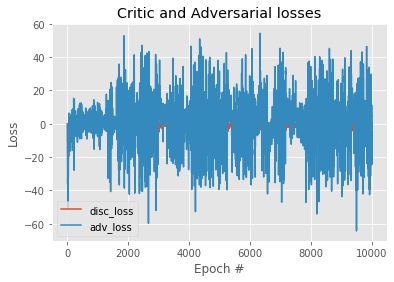

In [0]:
# Plot the losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(d_losses)), d_losses, label="disc_loss")
plt.plot(np.arange(0, len(a_losses)), a_losses, label="adv_loss")
plt.title("Critic and Adversarial losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

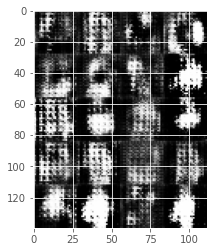

In [0]:
montage_1 =  plt.imread("vis500.png")
plt.imshow(montage_1)
plt.show()

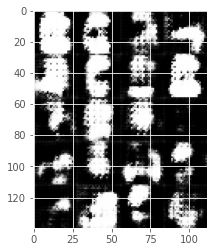

In [0]:
montage_2 =  plt.imread("vis2000.png")
plt.imshow(montage_2)
plt.show()

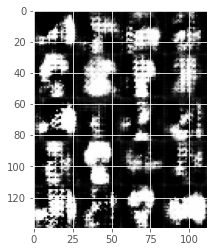

In [0]:
montage_3 =  plt.imread("vis5000.png")
plt.imshow(montage_3)
plt.show()

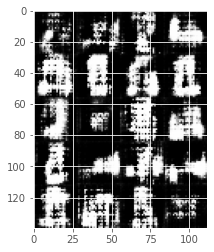

In [0]:
montage_4 =  plt.imread("vis7000.png")
plt.imshow(montage_4)
plt.show()

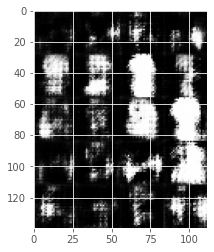

In [0]:
montage_5 =  plt.imread("vis9500.png")
plt.imshow(montage_5)
plt.show()